In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as net
import lammps_logfile

In [99]:
_dir = "/media/ankit/A_SSD/PhD/Granular project/LAMMPS/"

log = lammps_logfile.File(_dir+"log.lammps")
STEP = int(log.data_dict['Step'][-1])

file2 = open(_dir+'coord.du', 'r')
lines = [line.rstrip() for line in file2]

for num, line in enumerate(lines, 0):
    if 'ITEM' in line:
        if 'ITEM: TIMESTEP' in line:
            curr_timestep = int(lines[num+1])
        if 'ITEM: NUMBER OF ATOMS' in line:
            num_entries = int(lines[num+1])
            table = []
        if 'ITEM: ATOMS' in line:
            x = lines[num+1:num+1+num_entries]
            for i in range(len(x)):
                table.append(list(map(float, x[i].split(" "))))
                
grains = np.array(table.copy())

# HCP LATTICE
grains[:,2] += 10 
diff = min(grains[:,3])-10
grains[:,3] -= diff

_dir2 = "/media/ankit/A_SSD/PhD/Granular project/data/LSDEM/trial_0/"
theta = np.zeros(grains.shape[0]).reshape(-1,1)
positions = np.append(grains[:,2:4],theta,axis=1)
velocity = np.zeros(positions.shape)
morphID = np.append(grains.shape[0],np.zeros(grains.shape[0]))
np.savetxt(_dir2+"positions.dat",positions,fmt='%.5f')
np.savetxt(_dir2+"velocities.dat",velocity,fmt='%.5f')
np.savetxt(_dir2+"morphIDs.dat",morphID,fmt='%d')

In [96]:
max(grains[:,2])

220.0

# LSDEM to LAMMPS

In [ ]:
positions = pd.read_table("../data/trial_1/positionsEquil.dat",sep="\s+",names=['x','y','theta'])
lammps_file = positions[['x','y']].copy()
lammps_file['ID'] = np.arange(len(lammps_file))+1
lammps_file['Type'] = [1] * 100
lammps_file['Radius'] = [2*9.75]*100
lammps_file['density'] = [1]*100
lammps_file['z'] = [0.0]*100

data1 = lammps_file[['ID','Type','Radius','density','x','y','z']].to_numpy()
np.savetxt('../results/LSDEM',data1,fmt='%i %i %1.1f %1.1f %1.4f %1.4f %1.4f')

In [ ]:
# LSDEM Diamensions
nShapes = 1
nGrains = 100
nTot = 3000000
nOut = 500000
nShapes = 1
numParticlesRow = 10 #pluviation parameters for putting particles in a grid
numParticlesCol = nGrains/numParticlesRow 
grainRadiusVert = 25 #distances between particles in grid (vertical )
grainRadiusHorz = 25 #'' (horizontal)
startSpot = [grainRadiusHorz,grainRadiusVert] #bottom left of grid
rightWallPos = 275

particleProps = {} #material parameters of the particles   
particleProps["rho"] = 0.5
particleProps["mu"] = 0.5
particleProps["kn"] = 1e11 
particleProps["ks"] = 1e11 
particleProps["cresN"] = 0.4
particleProps["cresS"] = 0.5

# Infinite walls    
knWall = particleProps["kn"];
muWall = particleProps["mu"];

knWall, muWall

# Reading LSDEM data

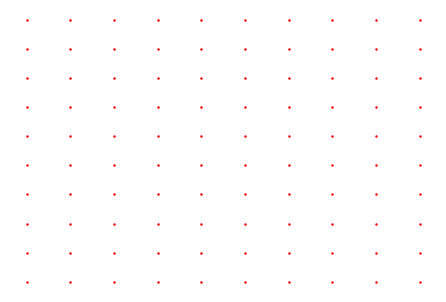

In [7]:
# Initial Positions

path = "../data/LSDEM/trial_0"
positions = pd.read_table(path+"/positions.dat",sep="\s+",names=['x','y','theta'])

Granular_network=net.Graph()
for index, row in positions.iterrows():
    Granular_network.add_node(index,pos=(row['x'],row['y']))

# path = "../data/LSDEM/trial_1"
# positions2 = pd.read_table(path+"/positions.dat",sep="\s+",names=['x','y','theta'])    
# for index, row in positions2.iterrows():
#     Granular_network.add_node(index+100,pos=(row['x'],row['y']))
    
pos = net.get_node_attributes(Granular_network,'pos')
net.draw(Granular_network,pos,edge_color='black',node_size=2,node_color='red')

In [8]:
path = "../data/LSDEM/trial_0"
positions = pd.read_table(path+"/positionsEquil.dat",sep="\s+",names=['x','y','theta'])

# Granular_network=net.Graph()
# for index, row in positions.iterrows():
#     Granular_network.add_node(index,pos=(row['x'],row['y']))

# pos = net.get_node_attributes(Granular_network,'pos')
# net.draw(Granular_network,pos,edge_color='black',node_size=2,node_color='blue')

LOC = np.zeros((100,100))
for index1, row1 in positions.iterrows():
    for index2, row2 in positions.iterrows():
        LOC[index1,index2] = np.sqrt((row1['x']-row2['x'])**2+(row1['y']-row2['y'])**2)

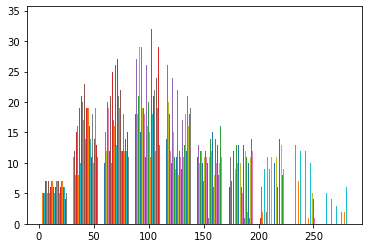

In [9]:
x = np.sort(np.unique(np.round(LOC,2)))
plt.hist(LOC)
plt.show()

In [11]:
# Final Positions

path = "../data/lsdem/trial_0"
velocties = pd.read_table(path+"/velocitiesOut.dat",sep="\s+",names=['vx','vy','vz'])
positions = pd.read_table(path+"/positionsOut.dat",sep="\s+",names=['x','y','theta'])
positions['magn'] = velocties['vx']**2 + velocties['vy']**2 + velocties['vz']**2

In [12]:
c_info = pd.read_table(path+"/c_info/cinfo_0.dat",sep="\s+",names=['ID1', 
                                                                    'ID2', 
                                                                    'cfx', 
                                                                    'cfy', 
                                                                    'cnx', 
                                                                    'cny', 
                                                                    'cpx', 
                                                                    'cpy'])
c_info['cf'] = np.sqrt(c_info['cfx']**2+c_info['cfy']**2)
c_info['cn'] = np.sqrt(c_info['cnx']**2+c_info['cny']**2)

# c_info.plot.scatter(x='cpx', y='cpy',ax=ax,c='cf')
# c_info.plot.scatter(x='cpx', y='cpy',ax=ax,c='cn')

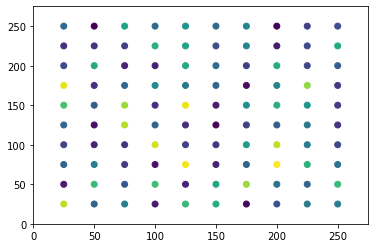

In [13]:
from matplotlib import animation

from matplotlib.animation import FuncAnimation 
# t = np.linspace(0, 100, 1000)
t = range(5)
fig, ax = plt.subplots()
ax.axis([0, 275, 0, 275])
l = ax.scatter([],[])

def animate(i):
    particles_posn = [[positions['x'][j], positions['y'][j]] for j in range(i*100,(i+1)*100)]
    particles_vel = [positions['magn'][j] for j in range(i*100,(i+1)*100)]
    l.set_offsets(np.array(particles_posn))
    l.set_array(np.array(particles_vel))

ani = FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())

NetworkXError: Node 5.0 has no position.

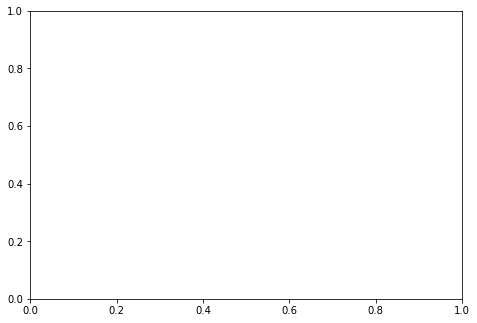

In [17]:
# Since positons are stored for each time step
positions_local = positions[-10:].reset_index()

v = c_info['cf']
v = 10*(v - v.min()) / (v.max() - v.min())

Granular_network=net.Graph()
for index, row in positions_local.iterrows():
    Granular_network.add_node(index,pos=(row['x'],row['y']))
    
for index, row in c_info.iterrows():
    Granular_network.add_edge(row['ID1'], row['ID2'], weight=v[index])

edges = Granular_network.edges()
weights = [Granular_network[u][v]['weight'] for u,v in edges]

pos=net.get_node_attributes(Granular_network,'pos')
net.draw(Granular_network,pos,width=weights,edge_color=weights,edge_cmap=plt.cm.YlOrRd)

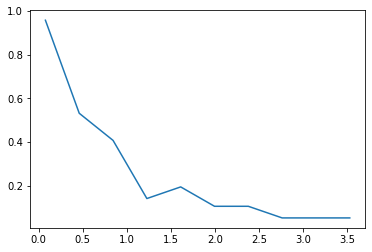

In [16]:
Y = c_info['cf'].to_numpy()
Y = Y/np.mean(Y)
# Y = np.sort(Y)
def function_hist(a,NBR):

    # 12 bins
    ini = np.min(a)
    final = np.max(a)
    bins = np.linspace(ini, final, NBR+1)
    hist = np.histogram(a, bins, density= True)
    
    return hist

hist = function_hist(Y, 10)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
bins = hist[1][:-1]
pdf = hist[0]
ax.plot(bins,pdf)
# ax.set_ylabel("$Log_{10}(P_N)$")
# ax.set_yscale('log')
# ax.set_xscale('log')

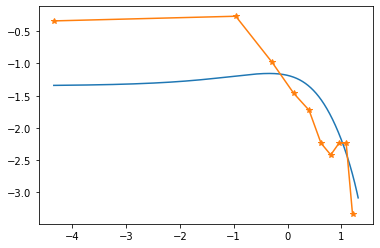

(0.013065034003155479, 0.013065034003155479, 0.013065034003155479)

In [70]:
from sklearn.neighbors import KernelDensity

Y = c_info['cf'].to_numpy()
Y = Y/np.mean(Y)

# Do kernel density estimation
kd = KernelDensity(kernel='gaussian', bandwidth=1).fit(Y.reshape(-1, 1))

# Plot the estimated densty
start = np.min(Y)  # Start of the range
end = np.max(Y)    # End of the range
N = 1000    # Number of evaluation points 
step = (end - start) / (N - 1)  # Step size
x = np.linspace(start, end, N)[:, np.newaxis]  # Generate values in the range
kd_vals = kd.score_samples(x)
plt.plot(np.log(x), kd_vals)

hist = function_hist(Y, 10)
bins = hist[1][:-1]
pdf = hist[0]
plt.plot(np.log(bins),np.log(pdf),'*-')
# Show the plots
plt.show()

np.min(x), np.min(bins), start

# Definition of force chains

In [ ]:
cForces = c_info[['cnx','cny']].to_numpy()
cForceMags = c_info['cn'].to_numpy()
cForceMax = np.percentile(cForceMags,50)
mask = cForceMags > cForceMax 
nMask = len(np.where(mask)[0]) #number of grains satisfying condition above 
cForces[mask] = [cForces[mask][i]/cForceMags[mask][i]*cForceMax for i in range(nMask)] #set biggest forces = 95% 
cForcesNormalized = cForces/cForceMax #normalize all forces by 95% force 
cForcesNormalizedMags = np.linalg.norm(cForcesNormalized,axis=1) #get magnitude of normalized forces

In [ ]:
Granular_network=net.Graph()
for index, row in positions.iterrows():
    Granular_network.add_node(index,pos=(row['x'],row['y']))
    
for index, row in c_info.iterrows():
    if(mask[index]):
        Granular_network.add_edge(row['ID1'], row['ID2'], weight=cForcesNormalizedMags[index])

edges = Granular_network.edges()
weights = [Granular_network[u][v]['weight'] for u,v in edges]

pos=net.get_node_attributes(Granular_network,'pos')
net.draw(Granular_network,pos,width=weights)

## Properties of graphs

In [ ]:
def connected_component_subgraphs(G):
    for c in net.connected_components(G):
        yield G.subgraph(c)

print("is Graph connected ", net.is_connected(Granular_network))
sub_graphs = list(connected_component_subgraphs(Granular_network))

largest_fully_connected_graph = sub_graphs[0]
diameter = net.diameter(largest_fully_connected_graph)

degree_sequence = list(Granular_network.degree())

nb_arr = len(Granular_network.edges())
avg_degree = np.mean(np.array(degree_sequence)[:,1])
med_degree = np.median(np.array(degree_sequence)[:,1])
max_degree = max(np.array(degree_sequence)[:,1])
min_degree = np.min(np.array(degree_sequence)[:,1])

print("Number of nodes : " + str(100))
print("Number of edges : " + str(nb_arr))
print("Maximum degree : " + str(max_degree))
print("Minimum degree : " + str(min_degree))
print("Average degree : " + str(avg_degree))
print("Median degree : " + str(med_degree))

degree_freq = np.array(net.degree_histogram(Granular_network)).astype('float')
plt.figure(figsize=(12, 8))
plt.stem(degree_freq)
plt.ylabel("Frequence")
plt.xlabel("Degree")
plt.show()

Prelimindary analysis

Choose definition of force chains

Need to normalize the force transfer with respect to depth

force = "normal force, contact force"

force v/s posn x

force v/s posn y

force v/s number of contacts

Clustering algorithms

# Reference codes

In [ ]:
# G = nx.random_geometric_graph(20,0)
# G=nx.Graph()

# G.add_node("a")
# G.add_nodes_from(["b","c"])

# G.add_edge(1,2)
# edge = ("d", "e")
# G.add_edge(*edge)
# edge = ("a", "b")
# G.add_edge(*edge)

# print("Nodes of graph: ")
# print(G.nodes())
# print("Edges of graph: ")
# print(G.edges())

net.draw(G)
# plt.savefig("simple_path.png") # save as png
plt.show() # display

In [ ]:
for i in range(3):
    if(i!=25 and i!=71):
        print(i)
        positions = pd.read_table("../data/lsdem/trial_"+str(i)+"/positionsEquil.dat",sep="\s+",names=['x','y','theta'])

        c_info = pd.read_table("../data/lsdem/trial_"+str(i)+"/c_info/cinfo_0.dat",sep="\s+",names=['ID1', 
                                                                                     'ID2', 
                                                                                     'cfx', 
                                                                                     'cfy', 
                                                                                     'cnx', 
                                                                                     'cny', 
                                                                                     'cpx', 
                                                                                     'cpy'])
        c_info['cf'] = np.sqrt(c_info['cfx']**2+c_info['cfy']**2)
        c_info['cn'] = np.sqrt(c_info['cnx']**2+c_info['cny']**2)
#         c_t = c_info[c_info.columns[2:4]].to_numpy()-c_info[c_info.columns[4:6]].to_numpy()

        
        Y = c_info['cn'].to_numpy()
        Y = Y/np.mean(Y)

        # Do kernel density estimation
        kd = KernelDensity(kernel='gaussian', bandwidth=1).fit(Y.reshape(-1, 1))

        fig = plt.figure(figsize=(2,2))
        # Plot the estimated densty
        start = np.min(Y)  # Start of the range
        end = np.max(Y)    # End of the range
        N = 1000    # Number of evaluation points 
        step = (end - start) / (N - 1)  # Step size
        x = np.linspace(start, end, N)[:, np.newaxis]  # Generate values in the range
        kd_vals = np.exp(kd.score_samples(x))
        plt.plot(np.log(x), np.log(kd_vals))

        # Show the plots
        plt.show()
#         plt.savefig("../data/lsdem/cn"+str(i)+".png")

In [ ]:
from matplotlib.collections import LineCollection

def computeForceChains(cinfo, cLen=20, cWid=0.5, color='black'):
    
    if cinfo.ndim > 1:
        cLocs = cinfo[:,6:8]
        cForces = cinfo[:,2:4]
        cForceMags = np.linalg.norm(cForces,axis=1)
        # Get forces higher than avg and normalize them    
        cForceMax = np.percentile(cForceMags,95)
        mask = cForceMags > cForceMax #bool array of super high forces 
        nMask = len(np.where(mask)[0]) #number of grains satisfying condition above 
        print (mask,nMask,cForces[mask])
        cForces[mask] = [cForces[mask][i]/cForceMags[mask][i]*cForceMax for i in range(nMask)] #set biggest forces = 95% 
        cForcesNormalized = cForces/cForceMax #normalize all forces by 95% force 
        cForcesNormalizedMags = np.linalg.norm(cForcesNormalized,axis=1) #get magnitude of normalized forces
        
        # Create collection of lines representing force chains
        lines = []
        for i in range(len(cLocs)):
            [x1, y1] = cLocs[i] - cForcesNormalized[i]*cLen/2
            [x2, y2] = cLocs[i] + cForcesNormalized[i]*cLen/2
            lines.append([(x1,y1),(x2,y2)])  
        
        # Collect all to a LineCollection
        lwd = cForcesNormalizedMags * cWid 
        lCol = LineCollection(lines, color=color, linewidths=lwd)
    else:
        lCol = LineCollection([], color=color, linewidths=cWid)

    return lCol

fig, ax = plt.subplots(figsize = (5,5))
ax.set_xlim(0,275)
ax.set_ylim(0,275)
ax.autoscale_view()

cLen = 30.; cWid = 2    
forceChains = computeForceChains(c_info.to_numpy(),cLen,cWid,'b')
ax.add_collection(forceChains)  